In [1]:
import pandas as pd
import numpy as np
# https://www.kaggle.com/code/carlmcbrideellis/feature-selection-using-the-boruta-shap-package
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from xgboost import XGBClassifier
import pickle
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from xgboost import plot_importance
from matplotlib import pyplot
# Perform GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
#from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_sample_weight

In [2]:
data = pd.read_csv("data_with_new_features.csv")

In [3]:
data.isnull().sum()

loan_id                         0
age                             0
income                          0
loan_amount                     0
credit_score                    0
months_employed                 0
num_credit_lines                0
interest_rate                   0
loan_term                       0
dtiratio                        0
education                       0
employment_type                 0
marital_status                  0
has_mortgage                    0
has_dependents                  0
loan_purpose                    0
has_co_signer                   0
default                         0
income_to_loan_ratio            0
empl_sta                        0
loan_pay_to_inc_ratio           0
credit_util_ratio               0
credit_age_factor               0
interest_payment_burden         0
income_to_interest_ratio        0
credit_income_inter             0
high_dti_flag                   0
marital_status_dependents       0
employment_type_loan_purpose    0
dtype: int64

In [4]:
data_new = data.copy()

Since there is a high level of class imbalance in the target variable for <code>default</code>, we will use the <code>stratify</code> option while splitting the data into train, validation, and test sets.

In [5]:
y = data_new["default"]
del data_new["default"]

In [6]:
df_full_train, df_test, y_full_train, y_test = train_test_split(data_new, y, stratify = y, test_size = 0.2, random_state = 1)

df_train, df_val, y_train, y_val = train_test_split(df_full_train, y_full_train, stratify =y_full_train,  test_size = 0.25, random_state = 1)

In [7]:
df_full_train = df_full_train.reset_index(drop = True)
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

In [8]:
y_full_train = y_full_train.values
y_train = y_train.values
y_val = y_val.values
y_test = y_test.values

In [9]:
full_train_dicts = df_full_train.to_dict(orient = 'records')
train_dicts = df_train.to_dict(orient = 'records')
val_dicts = df_val.to_dict(orient = 'records')
test_dicts = df_test.to_dict(orient = 'records')

In [10]:
#I will apply one-hot encoding to the dataset

In [11]:
# I was getting a memory error, so I set sparse=True for the DictVectorizer.
dv = DictVectorizer(sparse = True)
dv.fit(train_dicts)
#X_full_train_new = dv.transform(full_train_dicts)
X_train_new = dv.transform(train_dicts)
X_val_new = dv.transform(val_dicts)
X_test_new = dv.transform(test_dicts)

ValueError: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1223, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\utils\validation.py", line 1301, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\utils\validation.py", line 1012, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\utils\_array_api.py", line 751, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: float() argument must be a string or a real number, not 'dict'


# Hyperparameter Tuning for Logistic Regression

In [126]:
# Create a pipeline with DictVectorizer and RandomForestClassifier


pipeline = Pipeline([
    ('vectorizer', DictVectorizer(sparse=True)),  # Convert categorical features into a sparse matrix
    ('classifier', LogisticRegression(max_iter=1000,class_weight='balanced', random_state =1)) # Random Forest classifier
])


In [127]:

# Hyperparameter grid to search
param_grid = {
    'classifier__C': [0.1, 1, 10],                # Regularization strength (lower values = stronger regularization)
    'classifier__solver': ['liblinear', 'saga'],  # Solvers to use for optimization
    'classifier__penalty': ['l2', 'elasticnet'],  # Type of regularization
    'classifier__max_iter': [100, 200, 500]       # Maximum number of iterations for optimization
}

In [128]:

grid_search_lr =RandomizedSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1, n_iter = 20)
# Fit the model
grid_search_lr.fit(full_train_dicts, y_full_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
40 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vectorizer', DictVectorizer()),
                                             ('classifier',
                                              LogisticRegression(class_weight='balanced',
                                                                 max_iter=1000,
                                                                 random_state=1))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'classifier__C': [0.1, 1, 10],
                                        'classifier__max_iter': [100, 200, 500],
                                        'classifier__penalty': ['l2',
                                                                'elasticnet'],
                                        'classifier__solver': ['liblinear',
                                                               'saga']},
                   verbose=1)

In [129]:
best_lr = grid_search_lr.best_score_
print(best_lr)

0.6230510583487663


In [130]:
print("Best parameters:", grid_search_lr.best_params_)

Best parameters: {'classifier__solver': 'liblinear', 'classifier__penalty': 'l2', 'classifier__max_iter': 500, 'classifier__C': 1}


__Best parameters: {'classifier__solver': 'liblinear', 'classifier__penalty': 'l2', 'classifier__max_iter': 500, 'classifier__C': 1}__


# Hyperparameter Tuning for RandomForest Classifier

In [100]:
pipeline = Pipeline([
    ('vectorizer', DictVectorizer(sparse=True)),  # Convert categorical features into a sparse matrix
    ('classifier', RandomForestClassifier()) # Random Forest classifier
])


In [103]:

param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300, 400, 500],          # Number of trees in the forest (higher = more accurate but slower)
    'classifier__max_depth': [None, 10, 20, 30, 40, 50],             # Max depth of the trees (None means nodes are expanded until all leaves are pure)
    'classifier__min_samples_split': [2, 5, 10],                     # Minimum samples required to split an internal node
    'classifier__min_samples_leaf': [1, 2, 4],                       # Minimum samples required at a leaf node
    'classifier__max_features': ['auto', 'sqrt', 'log2'],            # Number of features to consider when looking for the best split
    'classifier__bootstrap': [True, False],                          # Whether to use bootstrap sampling (True is most common)
    'classifier__class_weight': ['balanced'],                  # Use balanced weights to deal with imbalanced classes
    'classifier__max_samples': [None, 0.8, 0.9],                     # Number of samples to train each tree (only when bootstrap=True)
    'classifier__oob_score': [True, False],                          # Out-of-bag score to get unbiased estimate of model performance
    'classifier__random_state': [1]                                 # For reproducibility
}

In [106]:
random_search_rf =RandomizedSearchCV(pipeline, param_grid_rf, cv=5, n_jobs=-1, verbose=1, n_iter = 20)
# Fit the model
random_search_rf.fit(full_train_dicts, y_full_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vectorizer', DictVectorizer()),
                                             ('classifier',
                                              RandomForestClassifier())]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'classifier__bootstrap': [True, False],
                                        'classifier__class_weight': ['balanced'],
                                        'classifier__max_depth': [None, 10, 20,
                                                                  30, 40, 50],
                                        'classifier__max_features': ['auto',
                                                                     'sqrt',
                                                                     'log2'],
                                        'classifier__max_samples': [None, 0.8,
                                                                    0.9],
                                        'classifier__min_samples_leaf': [1, 2,
                                                                         4],
                                        'classifier__min_samples_split': [2, 5,
                                                                          10],
                                        'classifier__n_estimators': [100, 200,
                                                                     300, 400,
                                                                     500],
                                        'classifier__oob_score': [True, False],
                                        'classifier__random_state': [1]},
                   verbose=1)

In [107]:
print("Best parameters:", random_search_rf.best_params_)

Best parameters: {'classifier__random_state': 1, 'classifier__oob_score': False, 'classifier__n_estimators': 500, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_samples': 0.9, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 40, 'classifier__class_weight': 'balanced', 'classifier__bootstrap': True}



print("Best parameters:", random_search_rf.best_params_)
Best parameters: {'classifier__random_state': 1, 'classifier__oob_score': False, 'classifier__n_estimators': 500, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_samples': 0.9, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 40, 'classifier__class_weight': 'balanced', 'classifier__bootstrap': True}

In [119]:
best_rf = random_search_rf.best_score_
print(best_rf)

0.7268610772426863


# Hyperparameter Tuning with Xgboost Classifier

In [120]:
# Define the pipeline
pipeline = Pipeline([
    ('vectorizer', DictVectorizer(sparse=True)),     # Converts dictionary data to numeric
    ('classifier', XGBClassifier(use_label_encoder=False, random_state=1 ))
])


In [121]:
param_dist = {
    'classifier__n_estimators': [100, 200, 300, 400, 500],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'classifier__gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'classifier__reg_alpha': [0, 0.01, 0.1, 1],
    'classifier__reg_lambda': [1, 1.5, 2, 3],
    'classifier__scale_pos_weight': [1, 5, 10, 20, 30]  # Adjust for class imbalance
}

In [122]:
random_search_xgb = RandomizedSearchCV(pipeline, param_dist, cv=5, n_jobs=-1, verbose=1, n_iter = 20)
# Fit the model
random_search_xgb.fit(full_train_dicts, y_full_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\s

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vectorizer', DictVectorizer()),
                                             ('classifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            feature_types=None,
                                                            gamma=None,
                                                            grow_policy=None,
                                                            i...
                                        'classifier__gamma': [0, 0.1, 0.2, 0.3,
                                                              0.4],
                                        'classifier__learning_rate': [0.01,
                                                                      0.05, 0.1,
                                                                      0.2,
                                                                      0.3],
                                        'classifier__max_depth': [3, 5, 7, 10],
                                        'classifier__n_estimators': [100, 200,
                                                                     300, 400,
                                                                     500],
                                        'classifier__reg_alpha': [0, 0.01, 0.1,
                                                                  1],
                                        'classifier__reg_lambda': [1, 1.5, 2,
                                                                   3],
                                        'classifier__scale_pos_weight': [1, 5,
                                                                         10, 20,
                                                                         30],
                                        'classifier__subsample': [0.6, 0.7, 0.8,
                                                                  0.9, 1.0]},
                   verbose=1)

In [123]:
best_xgb = random_search_xgb.best_score_
print(best_xgb)

0.8863014482367149


In [125]:
print("Best parameters:", random_search_xgb.best_params_)

Best parameters: {'classifier__subsample': 0.9, 'classifier__scale_pos_weight': 1, 'classifier__reg_lambda': 1, 'classifier__reg_alpha': 0.1, 'classifier__n_estimators': 200, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.05, 'classifier__gamma': 0.3, 'classifier__colsample_bytree': 0.9}


Best parameters: {'classifier__subsample': 0.9, 'classifier__scale_pos_weight': 1, 'classifier__reg_lambda': 1, 'classifier__reg_alpha': 0.1, 'classifier__n_estimators': 200, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.05, 'classifier__gamma': 0.3, 'classifier__colsample_bytree': 0.9}


In [ ]:
#https://forecastegy.com/posts/xgboost-imbalanced-data-scale_pos_weight-python/

Tabnet Hyperparameter search

In [13]:
# Compute class weights to handle class imbalance
#class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
#class_weights_dict = dict(enumerate(class_weights))

# Feature Importance Search

In [71]:
#{'classifier__subsample': 0.9, 'classifier__scale_pos_weight': 1, 'classifier__reg_lambda': 1, 'classifier__reg_alpha': 0.1, 'classifier__n_estimators': 200, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.05, 'classifier__gamma': 0.3, 'classifier__colsample_bytree': 0.9}

In [14]:
print(dv.get_feature_names_out())

['age' 'credit_age_factor' 'credit_income_inter' ...
 'marital_status_dependents=Single_Yes' 'months_employed'
 'num_credit_lines']


In [15]:
# fit model no training data
model = XGBClassifier(params = {'subsample': 0.9, 'scale_pos_weight': 1, 'reg_lambda': 1,'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 5,
'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.9}, objective="binary:logistic", feature_name=dv.get_feature_names_out())
model.fit(X_train_new, y_train,sample_weight=sample_weights)
# plot feature importance


C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:48:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "feature_name", "params" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              feature_name=array(['age', 'credit_age_factor', 'credit_income_inter', ...,
       'marital_status_dependents=Single_Yes', 'months_employed',
       'num_credit_lin...
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

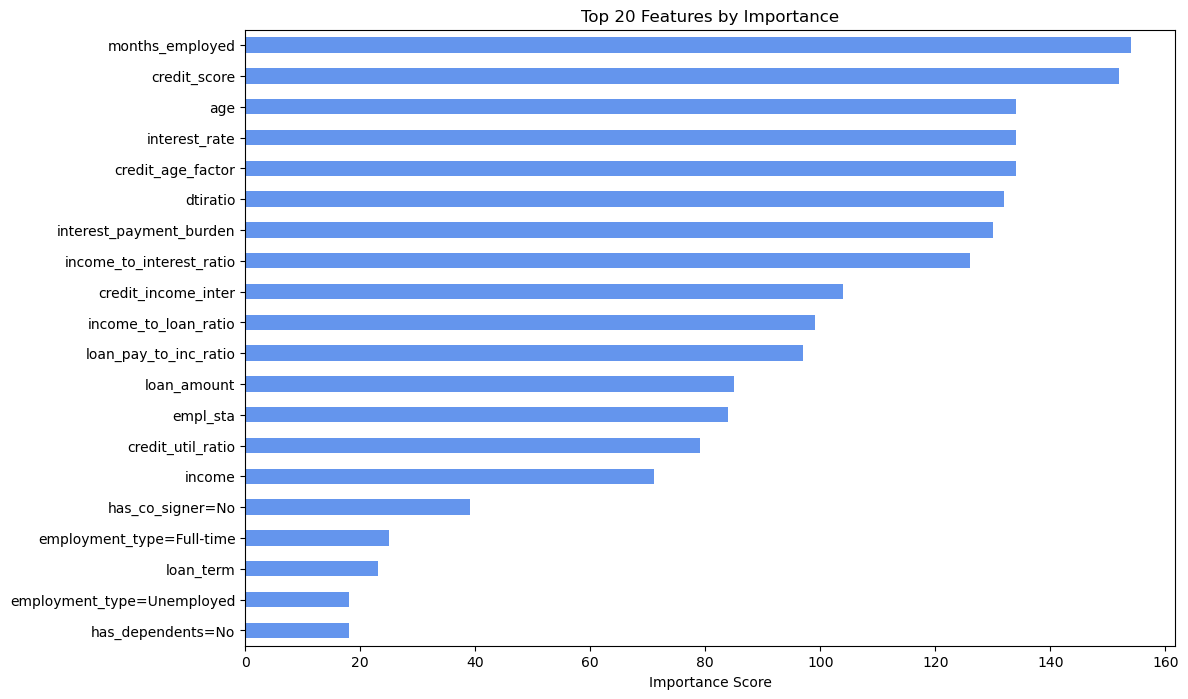

In [17]:

# Assuming `dv` is your DictVectorizer instance
feature_names = dv.get_feature_names_out()

# Retrieve feature importance scores
feature_importance = model.get_booster().get_score(importance_type='weight')
keys = list(feature_importance.keys())
# Convert keys from indices (like "f0", "f1", ...) to actual feature names
keys_named = [feature_names[int(key[1:])] for key in keys]  # Remove "f" prefix and map to feature_names
values = list(feature_importance.values())

# Create DataFrame with feature importance scores
data = pd.DataFrame(data=values, index=keys_named, columns=["score"]).sort_values(by="score", ascending=False)

# Plot the top 15 features
data.nlargest(20, columns="score").plot(kind='barh', figsize=(12, 8), legend=False, color = "cornflowerblue")
plt.xlabel("Importance Score")
plt.title("Top 20 Features by Importance")
plt.gca().invert_yaxis()  # To show the highest importance on top
plt.savefig("feature_importance.png", bbox_inches='tight')
plt.show()

In [84]:
data.to_csv('feature_importances_xgb.csv')

In [85]:
imp = pd.read_csv('feature_importances_xgb.csv')

In [86]:
imp.head()

,Unnamed: 0,score
0,months_employed,154.0
1,credit_score,152.0
2,age,134.0
3,interest_rate,134.0
4,credit_age_factor,134.0
